<a href="https://colab.research.google.com/github/LucasFurlan12/Trabalho-LEA---Lucas-Ferraz-Furlan/blob/main/TrabLea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import os
import time
import random

In [ ]:
def coletando_dados(base_url_noticias, paginas):
    headers = {
        "User-Agent": "Mozilla/5.0 (acer aspire 3; full HD 1080) applewebkit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36"
    }
    incremento = 0  #Incremento que será o controlador para trocarmos de página
    todas_noticias = []  #Lista para armazenar todas as notícias invadidas

    for numero_pagina in range(1, paginas + 1):
        url_pagina = f"{base_url_noticias}?b_start:int={incremento}"
        print(f"\nINvadindo dados da página {numero_pagina}: {url_pagina}")

        try:
            resposta = requests.get(url_pagina, headers=headers, timeout=10)
            resposta.raise_for_status()
            soup = BeautifulSoup(resposta.text, "html.parser")

            #Localizando os links das notícias dessa página que estamos
            links_noticias = []
            for a in soup.find_all("a", class_="summary url"):
                links_noticias.append(a["href"])

            for link_completo in links_noticias:
                print(f"Invadindo: {link_completo}")

                try:
                    resposta_noticia = requests.get(link_completo, headers=headers, timeout=10)
                    resposta_noticia.raise_for_status()
                    soup_noticia = BeautifulSoup(resposta_noticia.text, "html.parser")

                    titulo = soup_noticia.find("meta", property="og:title")
                    descricao = soup_noticia.find("meta", attrs={"name": "description"})
                    data = soup_noticia.find("meta", property="article:modified_time")
                    texto = soup_noticia.find("div", id="parent-fieldname-text")

                    noticia = {
                        "titulo": titulo["content"] if titulo else "Sem título",
                        "descricao": descricao["content"] if descricao else "Sem descrição",
                        "data_publicacao": data["content"] if data else "Data não capturada",
                        "conteudo": texto.get_text(separator="\n").strip() if texto else "Texto não capturado",
                        "link": link_completo
                    }

                    todas_noticias.append(noticia)
                    print(f"Notícia invadida: {noticia['titulo']}")

                    time.sleep(random.uniform(1, 3))#Para evitar bans

                except Exception as erro_noticia:
                    print(f"Erro {link_completo} Detalhe {erro_noticia}")

        except Exception as erro_pagina:
            print(f"Erro {url_pagina} Detalhe {erro_pagina}")

        incremento += 45  #cada link de cada página que aumenta, aumenta 45 unidades no último número do link (movimento padrão)

    return todas_noticias

def salvar_todas_noticias(noticias, caminho_arquivo):
    try:
        with open(caminho_arquivo, "w", encoding="utf-8") as arquivo:
            json.dump(noticias, arquivo, ensure_ascii=False, indent=4)
        print(f"notícias foram salvas no arquivo: {caminho_arquivo}")
    except Exception as erro:
        print(f"Erro: {erro}")

url_base = "https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/ultimas-noticias"
caminho_arquivo_json = "todas_noticias.json"

noticias_coletadas = coletando_dados(url_base, 5)
salvar_todas_noticias(noticias_coletadas, caminho_arquivo_json)




INvadindo dados da página 1: https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/ultimas-noticias?b_start:int=0
Invadindo: https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/noticias/2024/12/presidente-lula-sanciona-lei-que-moderniza-tributacao-de-importacoes-e-promove-mobilidade-verde
Notícia invadida: Presidente Lula sanciona lei que moderniza tributação de importações e promove mobilidade verde
Invadindo: https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/noticias/2024/12/presidente-assina-mp-para-recuperacao-de-areas-afetadas-por-eventos-climaticos-extremos
Notícia invadida: Presidente assina MP para recuperação de áreas afetadas por eventos climáticos extremos
Invadindo: https://www.gov.br/planalto/pt-br/acompanhe-o-planalto/noticias/2024/12/201ceste-e-o-momento-de-renovarmos-nossa-esperanca201d-diz-lula-em-pronunciamento-de-natal
Notícia invadida: “Este é o momento de renovarmos nossa esperança”, diz Lula em pronunciamento de Natal
Invadindo: https://www.gov.br/planal

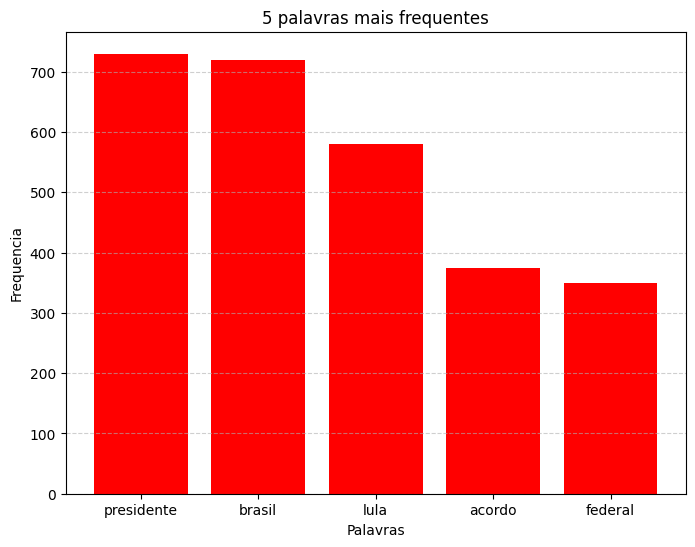

In [10]:
import re
from collections import Counter
import matplotlib.pyplot as plt
#primeiramente vamos ignorar palavras que não são de nosso interesse
#considerar na análise palavras comuns para serem ignoradas
palavras_para_ignorar = {
    "de", "e", "o", "a", "que", "do", "da", "em", "um", "para", "com",
    "não", "é", "os", "no", "se", "na", "por", "uma", "as", "dos", "como",
    "mas", "foi", "ao", "ele", "das", "tem", "à", "seu", "sua", "ou",
    "quando", "muito", "há", "nos", "já", "está", "eu", "também", "só",
    "pelo", "pela", "até", "isso", "ela", "entre", "era", "depois", "sem",
    "mesmo", "aos", "ter", "seus", "quem", "nas", "me", "esse", "eles",
    "estão", "você", "tinha", "foram", "essa", "num", "nem", "suas",
    "meu", "às", "minha", "têm", "numa", "pelos", "elas", "havia",
    "sejam", "qual", "ser", "nós", "lhe", "deles", "essas", "esses",
    "pelas", "este", "dele", "tu", "te", "vocês", "vos", "lhes", "meus",
    "minhas", "teu", "tua", "teus", "tuas", "nosso", "nossa", "nossos",
    "nossas", "dela", "delas", "esta", "estes", "estas", "aquele",
    "aquela", "aqueles", "aquelas", "isto", "aquilo", "r", "mais"
}
#obs:por algum motivo desconhecido, a palavra "r" estava com muitas aparições, portanto, mesmo não sendo exatamente uma palavra, desconsiderei do estudo

arquivo_json = "todas_noticias.json"

# Fç para carregar os textos das notícias a partir do arquivo JSON
def obter_textos_arquivo(caminho_arquivo):
    textos_extraidos = []
    with open(caminho_arquivo, "r", encoding="utf-8") as f:
        dados = json.load(f)
        for noticia in dados:
            if "conteudo" in noticia and noticia["conteudo"] != "N/A":
                textos_extraidos.append(noticia["conteudo"])
    return textos_extraidos

# capturando os textos do arquivo JSON
textos_coletados = obter_textos_arquivo(arquivo_json)

if not textos_coletados:
    print("erro")
else:
    #juntando os textos em uma única string
    texto_concatenado = " ".join(textos_coletados)

    # separando palavras e removendo pontuações
    todas_palavras = re.findall(r'\b\w+\b', texto_concatenado.lower())

    # eliminando as palavras que não são importantes já definidas anteriormente
    palavras_relevantes = [palavra for palavra in todas_palavras if palavra not in palavras_para_ignorar]

    # frequência de cada palavra
    frequencias_palavras = Counter(palavras_relevantes)

    # 5 palavras mais frequentes
    top_palavras = frequencias_palavras.most_common(5)
    nomes_palavras, contagens = zip(*top_palavras)

    plt.figure(figsize=(8, 6))
    plt.bar(nomes_palavras, contagens, color="red")
    plt.title("5 palavras mais frequentes")
    plt.xlabel("Palavras")
    plt.ylabel("Frequencia")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

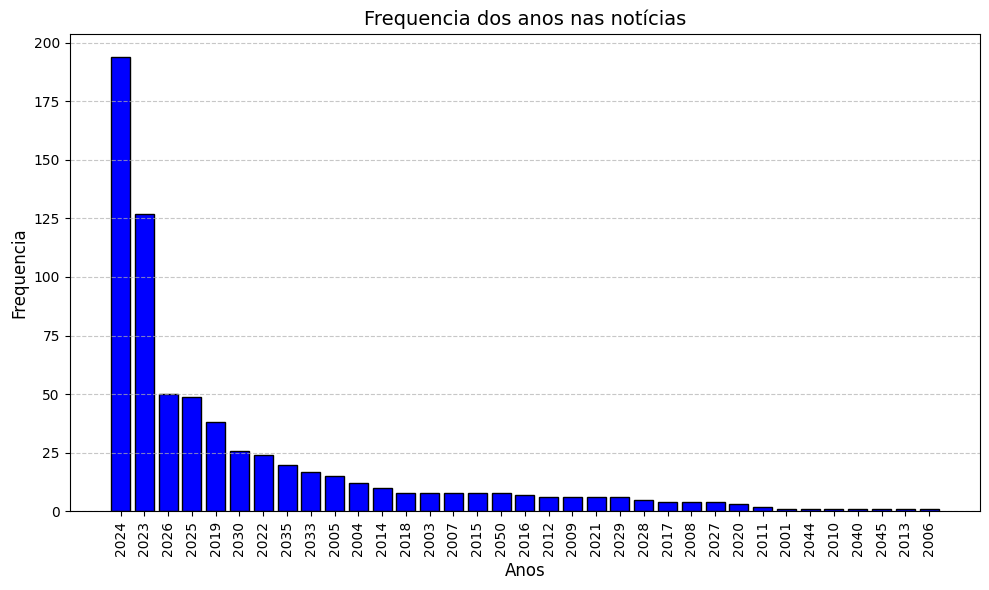

In [11]:
caminho_arquivo_json = "todas_noticias.json"

def extrair_textos_arquivo(arquivo):
    lista_textos = []
    try:
        with open(arquivo, "r", encoding="utf-8") as file:
            dados = json.load(file)
            for entrada in dados:
                if "conteudo" in entrada and entrada["conteudo"] != "ERRO":
                    lista_textos.append(entrada["conteudo"])
    except FileNotFoundError:
        print(f"Erro")
    except json.JSONDecodeError:
        print("Erro")
    return lista_textos
# Fç que conta a frequencia de anos desse século e adiciona na lista de contagem
def identificar_anos_em_textos(lista_textos):
    texto_unificado = " ".join(lista_textos)
    anos_encontrados = re.findall(r'\b20[0-9]{2}\b', texto_unificado)
    contagem = Counter(anos_encontrados)
    return contagem
# Fç que gera o gráfico com a frequencia de cada ano
def criar_grafico_frequencia_anos(contagem_anos):
    if not contagem_anos:
        print("erro")
        return
    anos, frequencias = zip(*contagem_anos.most_common())
    plt.figure(figsize=(10, 6))
    plt.bar(anos, frequencias, color="blue", edgecolor="black")
    plt.title("Frequencia dos anos nas notícias", fontsize=14)
    plt.xlabel("Anos", fontsize=12)
    plt.ylabel("Frequencia", fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

textos_noticias = extrair_textos_arquivo(caminho_arquivo_json)

# frequência dos anos encontrados nos textos e gerando o gráfico
frequencia_anos = identificar_anos_em_textos(textos_noticias)
criar_grafico_frequencia_anos(frequencia_anos)


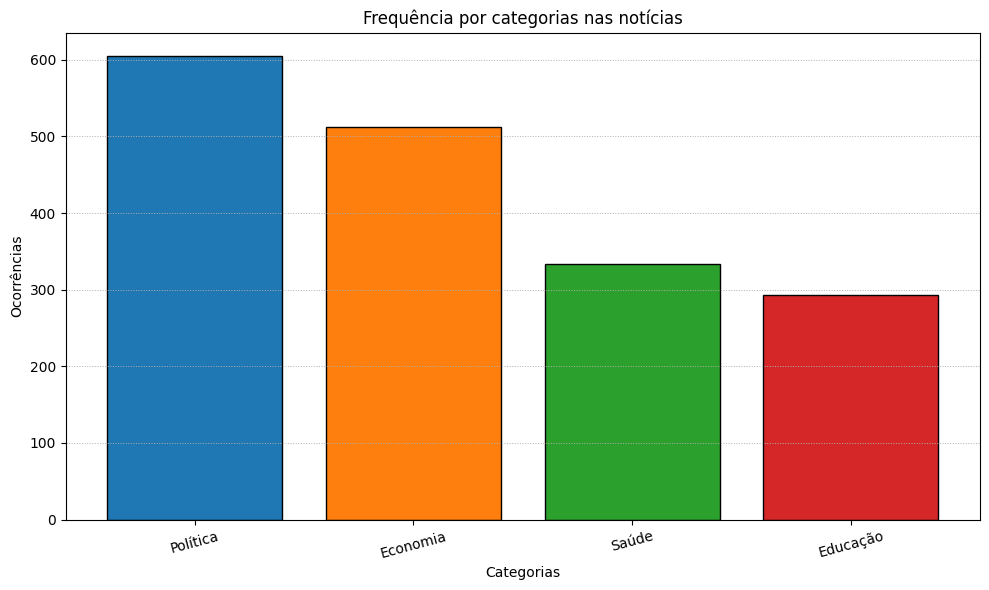

In [16]:
import matplotlib.pyplot as plt

# Função para calcular frequências
def calcular_frequencias(textos, categorias):
    # Inicializar variáveis para armazenar frequências
    frequencias = {}
    for categoria in categorias:
        total = 0
        palavras_chave = categorias[categoria]
        # Contar cada palavra-chave individualmente
        for palavra in palavras_chave:
            contador = 0
            for texto in textos:
                contador += texto.count(palavra)
            total += contador
        frequencias[categoria] = total
    return frequencias

# Função para criar gráficos
def plotar_grafico(frequencias):
    # Caso não existam frequências, exiba erro
    if len(frequencias) == 0:
        print("erro")
        return

    categorias = list(frequencias.keys())
    valores = list(frequencias.values())

    # Configuração do gráfico
    plt.figure(figsize=(10, 6))
    plt.bar(
        categorias,
        valores,
        color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"],
        edgecolor="black"
    )
    plt.title("Frequência por categorias nas notícias")
    plt.xlabel("Categorias")
    plt.ylabel("Ocorrências")
    plt.grid(axis="y", linestyle="dotted", linewidth=0.7)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

# Palavras que representam cada categoria
categorias_palavras = {
    "Política": ["política", "governo", "congresso", "parlamento", "senado"],
    "Economia": ["economia", "mercado", "dinheiro", "investimento", "imposto"],
    "Saúde": ["saúde", "hospital", "vacina", "médico", "tratamento"],
    "Educação": ["educação", "escola", "ensino", "universidade", "professor"]
}

# Simula a extração de textos
textos_coletados = extrair_textos(caminho_arquivo_json)

# Calcular frequências das categorias
resultado_frequencias = calcular_frequencias(textos_coletados, categorias_palavras)

# Gerar gráfico
plotar_grafico(resultado_frequencias)


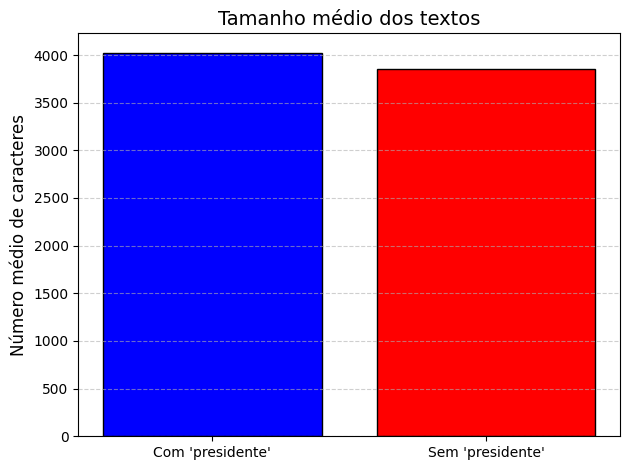

Tamanho médio dos textos com 'presidente': 4026.24 caracteres
Tamanho médio dos textos sem 'presidente': 3848.62 caracteres


In [20]:
#Função para separar os textos com e sem a palavra-chave
def separar_textos_por_palavra(caminho_arquivo, palavra_chave):
    tamanhos_com=[]
    tamanhos_sem=[]

    try:
        with open(caminho_arquivo, "r", encoding="utf-8") as arquivo:
            conteudo =json.load(arquivo)
            for item in conteudo:
                if "conteudo" in item and item["conteudo"] != "N/A":
                    texto_atual = item["conteudo"]
                    if palavra_chave in texto_atual.lower():
                        tamanhos_com.append(len(texto_atual))
                    else:
                        tamanhos_sem.append(len(texto_atual))
    except Exception as e:
        print(f"Erro ao processar o arquivo {caminho_arquivo}: {e}")

    return tamanhos_com, tamanhos_sem

# Função para calcular a média de uma lista de valores
def calcular_media(lista):
    return sum(lista) / len(lista) if lista else 0

# Função para criar o gráfico de comparação
def criar_grafico_comparacao(valores, rotulos, titulo, eixo_y):
    if not valores or not rotulos:
        print("Erro: Dados insuficientes para o gráfico.")
        return

    plt.bar(rotulos, valores, color=["blue", "red"], edgecolor="black")
    plt.title(titulo, fontsize=14)
    plt.ylabel(eixo_y, fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Adotando presidente como a palavra chave
palavra_chave = "presidente"
tamanhos_com_palavra, tamanhos_sem_palavra = separar_textos_por_palavra(caminho_arquivo_json, palavra_chave)

# Calculando as médias de tamanho dos dois tipos de textos (com "presidente" e sem "presidente") e montanto o gráfico de barras com a média das duas
media_com =calcular_media(tamanhos_com_palavra)
media_sem =calcular_media(tamanhos_sem_palavra)

rotulos_grafico =["Com 'presidente'", "Sem 'presidente'"]
valores_medias =[media_com, media_sem]

criar_grafico_comparacao(
    valores_medias,
    rotulos_grafico,
    "Tamanho médio dos textos",
    "Número médio de caracteres"
)

print(f"Tamanho médio dos textos com 'presidente': {media_com:.2f} caracteres")
print(f"Tamanho médio dos textos sem 'presidente': {media_sem:.2f} caracteres")
